In [2]:
pip install -U albumentations

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/97/d3/cf3aab593209d1be5e4bca54aeea297225708bd25f06426d6b8ec3630a76/albumentations-2.0.5-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00
  Obtaining dependency information for pydantic>=2.9.2 from https://files.pythonhosted.org/packages/b0/1d/407b29780a289868ed696d1616f4aad49d6388e5a77f567dcd2629dcd7b8/pydantic-2.11.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 5.1 MB/s eta 0:00:00
  Obtaining dependency information for albucore==0.0.23 from https://files.pythonhosted.org/packages/3d/de/4d9298befa6ae0f21230378f55100dca364816e3734028ca2766f2eca263/albucore-0.0.23-py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python-headless>=4.9.0.80 from https://files.pythonhosted.org/packages/dd/5c/c139a78

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import seaborn as sns

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset class for GasHisSDB with Albumentations support
class GasHisSDBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform: Albumentations transform pipeline
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['normal', 'abnormal']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.samples = []
        
        # Collect samples
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                print(f"Warning: Directory {class_dir} does not exist or is not accessible")
                continue
                
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                    self.samples.append((
                        os.path.join(class_dir, img_name),
                        self.class_to_idx[class_name]
                    ))
        
        # Print dataset statistics
        self.normal_count = sum(1 for _, label in self.samples if label == 0)
        self.abnormal_count = sum(1 for _, label in self.samples if label == 1)
        print(f"Dataset loaded with {len(self.samples)} images:")
        print(f"  - Normal: {self.normal_count}")
        print(f"  - Abnormal: {self.abnormal_count}")
        
        # Safely calculate ratio
        if self.normal_count > 0:
            print(f"  - Ratio (Abnormal:Normal): {self.abnormal_count/self.normal_count:.2f}:1")
        else:
            print("  - Ratio: Cannot calculate (no normal samples found)")
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Load image with OpenCV for Albumentations compatibility
        try:
            # Read as BGR and convert to RGB
            image = cv2.imread(img_path)
            if image is None:
                print(f"Error loading image {img_path}")
                # Return a placeholder black image and the label
                image = np.zeros((120, 120, 3), dtype=np.uint8)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder black image and the label
            image = np.zeros((120, 120, 3), dtype=np.uint8)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        return image, label

# Define an enhanced CNN model with more gradual fully connected layer reduction
class GradualFCGastricCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(GradualFCGastricCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate flattened size after convolutions (for 120x120 input)
        # After 4 pooling layers with stride 2: 120 -> 60 -> 30 -> 15 -> 7
        flattened_size = 256 * 7 * 7  # 12,544
        
        # More gradual fully connected layer reduction
        # 12,544 -> 4096 -> 2048 -> 1024 -> 512 -> 256 -> 128 -> 64 -> 32 -> 2
        self.fc_layers = nn.Sequential(
            # FC Layer 1: 12,544 -> 4096
            nn.Linear(flattened_size, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            # FC Layer 2: 4096 -> 2048
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            # FC Layer 3: 2048 -> 1024
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            # FC Layer 4: 1024 -> 512
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            
            # FC Layer 5: 512 -> 256
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            
            # FC Layer 6: 256 -> 128
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            # FC Layer 7: 128 -> 64
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            # FC Layer 8: 64 -> 32
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            # Output Layer: 32 -> num_classes
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        # Store intermediate activations
        self.intermediate_activations = {}
        
        # Convolutional layers
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        self.intermediate_activations['conv1'] = x
        
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        self.intermediate_activations['conv2'] = x
        
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        self.intermediate_activations['conv3'] = x
        
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        self.intermediate_activations['conv4'] = x
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with gradual reduction
        x = self.fc_layers(x)
        
        return x

# Create a ResNet-based model with gradual FC layers
def create_gradual_fc_resnet_model(num_classes=2):
    model = models.resnet18(pretrained=True)
    
    # Freeze early layers
    for param in list(model.parameters())[:-30]:  # Freeze all except last few layers
        param.requires_grad = False
    
    # Get the number of features from the last layer
    num_ftrs = model.fc.in_features
    
    # Replace with gradual FC layers
    model.fc = nn.Sequential(
        # FC Layer 1: num_ftrs -> 2048
        nn.Linear(num_ftrs, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        
        # FC Layer 2: 2048 -> 1024
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        
        # FC Layer 3: 1024 -> 512
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        
        # FC Layer 4: 512 -> 256
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        
        # FC Layer 5: 256 -> 128
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        
        # FC Layer 6: 128 -> 64
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        
        # FC Layer 7: 64 -> 32
        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        
        # Output Layer: 32 -> num_classes
        nn.Linear(32, num_classes)
    )
    
    # Initialize model intermediate activations
    model.intermediate_activations = {}
    
    # Add hooks to capture intermediate activations
    def get_layer_activation(name):
        def hook(module, input, output):
            model.intermediate_activations[name] = output
        return hook
    
    # Register hooks for feature maps
    model.layer1.register_forward_hook(get_layer_activation('layer1'))
    model.layer2.register_forward_hook(get_layer_activation('layer2'))
    model.layer3.register_forward_hook(get_layer_activation('layer3'))
    model.layer4.register_forward_hook(get_layer_activation('layer4'))
    
    return model

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    # Track best model
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_f1 = 0.0  # Also track F1-score for imbalanced data
    
    # History for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Collect predictions and labels for F1 score
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # Calculate F1 score - handle case when there are no samples of a particular class
            try:
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            except:
                epoch_f1 = 0.0
                print("Warning: F1 score calculation failed - likely missing class in predictions")
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
            
            # Record history for plotting
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                history['train_f1'].append(epoch_f1)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                history['val_f1'].append(epoch_f1)
                
                # Learning rate scheduling
                scheduler.step(epoch_loss)
                
                # Deep copy the model if it's the best based on F1 score (better for imbalanced data)
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict().copy()
                    print(f"New best model (F1: {best_f1:.4f})")
        
        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    
    # Handle case where a class might not be present in the predictions
    try:
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Calculate class-specific metrics if both classes are present
        class_labels = sorted(list(set(all_labels)))
        if len(class_labels) > 1:
            precision_per_class = precision_score(all_labels, all_preds, average=None)
            recall_per_class = recall_score(all_labels, all_preds, average=None)
            f1_per_class = f1_score(all_labels, all_preds, average=None)
            
            precision_normal = precision_per_class[0] if 0 in class_labels else 0
            precision_abnormal = precision_per_class[1] if 1 in class_labels else 0
            recall_normal = recall_per_class[0] if 0 in class_labels else 0
            recall_abnormal = recall_per_class[1] if 1 in class_labels else 0
            f1_normal = f1_per_class[0] if 0 in class_labels else 0
            f1_abnormal = f1_per_class[1] if 1 in class_labels else 0
        else:
            print("Warning: Only one class present in test set")
            precision_normal = 0
            precision_abnormal = 0
            recall_normal = 0
            recall_abnormal = 0
            f1_normal = 0
            f1_abnormal = 0
    except:
        print("Warning: Error calculating precision/recall/f1 - check class balance")
        precision = 0
        recall = 0
        f1 = 0
        precision_normal = 0
        precision_abnormal = 0
        recall_normal = 0
        recall_abnormal = 0
        f1_normal = 0
        f1_abnormal = 0
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f'Test Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f} (Normal: {precision_normal:.4f}, Abnormal: {precision_abnormal:.4f})')
    print(f'Recall: {recall:.4f} (Normal: {recall_normal:.4f}, Abnormal: {recall_abnormal:.4f})')
    print(f'F1 Score: {f1:.4f} (Normal: {f1_normal:.4f}, Abnormal: {f1_abnormal:.4f})')
    print('\nConfusion Matrix:')
    print(cm)
    
    # Calculate and plot precision-recall curve if both classes present
    if len(set(all_labels)) > 1 and 1 in all_labels:
        try:
            from sklearn.metrics import precision_recall_curve, average_precision_score
            
            binary_labels = [1 if label == 1 else 0 for label in all_labels]
            precision_curve, recall_curve, _ = precision_recall_curve(binary_labels, all_probs[:, 1])
            avg_precision = average_precision_score(binary_labels, all_probs[:, 1])
            
            plt.figure(figsize=(8, 6))
            plt.plot(recall_curve, precision_curve, label=f'Abnormal (AP={avg_precision:.3f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve for Abnormal Class')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.savefig('precision_recall_curve.png')
            plt.show()
        except Exception as e:
            print(f"Error plotting precision-recall curve: {e}")
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_normal': precision_normal,
        'precision_abnormal': precision_abnormal,
        'recall_normal': recall_normal,
        'recall_abnormal': recall_abnormal,
        'f1_normal': f1_normal,
        'f1_abnormal': f1_abnormal,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels,
        'probabilities': all_probs
    }

# Function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 3, 3)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Validation F1')
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes=['Normal', 'Abnormal']):
    plt.figure(figsize=(8, 6))
    
    # Calculate metrics from confusion matrix
    total = np.sum(cm)
    accuracy = (cm[0, 0] + cm[1, 1]) / total if total > 0 else 0
    
    # Calculate other metrics (handle division by zero)
    precision_normal = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    precision_abnormal = cm[1, 1] / (cm[0, 1] + cm[1, 1]) if (cm[0, 1] + cm[1, 1]) > 0 else 0
    
    recall_normal = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    recall_abnormal = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    
    # Plot confusion matrix with seaborn for better styling
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
               xticklabels=classes, yticklabels=classes)
    
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.3f}\n' +
              f'Normal - Precision: {precision_normal:.3f}, Recall: {recall_normal:.3f}\n' +
              f'Abnormal - Precision: {precision_abnormal:.3f}, Recall: {recall_abnormal:.3f}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# Helper class for applying transforms to subsets
class TransformedSubset(Dataset):
    """Apply transform to a subset of a dataset"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            augmented = self.transform(image=x)
            x = augmented['image']
        return x, y
        
    def __len__(self):
        return len(self.subset)

# Define augmentations for histopathology images
def get_albumentation_transforms():
    # Advanced augmentations specifically tailored for H&E stained histopathology images
    train_transform = A.Compose([
        # Spatial augmentations
        A.Resize(120, 120),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
        
        # Color augmentations for H&E stained images
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        
        # Add some noise occasionally
        A.GaussNoise(var_limit=(10, 50), p=0.3),
        
        # Basic blur
        A.GaussianBlur(blur_limit=3, p=0.3),
        
        # Normalize and convert to tensor
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # Simple transform for validation/test
    eval_transform = A.Compose([
        A.Resize(120, 120),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    return train_transform, eval_transform

# Main execution function with class weighting for imbalanced data
def run_weighted_gradual_fc_training(data_dir, batch_size=32, num_epochs=20, learning_rate=0.001, model_type='custom'):
    # Get transforms
    train_transform, eval_transform = get_albumentation_transforms()
    
    # Create dataset
    dataset = GasHisSDBDataset(root_dir=data_dir)
    
    # Get class counts for weighting
    normal_count = dataset.normal_count
    abnormal_count = dataset.abnormal_count
    total_count = len(dataset)
    
    # Calculate class weights for loss function (if normal_count is 0, handle it)
    if normal_count == 0:
        print("Warning: No normal samples found. Using default weights.")
        weights = torch.tensor([1.0, 1.0])
    else:
        # Method 1: Inverse class frequency
        weights_inverse = torch.tensor([total_count/normal_count, total_count/abnormal_count])
        
        # Method 2: Inverse square root of class frequency (less aggressive balancing)
        weights_sqrt = torch.tensor([
            np.sqrt(total_count/normal_count), 
            np.sqrt(total_count/abnormal_count)
        ])
        
        # Method 3: Balanced weighting (sum to 1)
        weights_balanced = torch.tensor([abnormal_count/total_count, normal_count/total_count])
        
        # Choose the weighting method (method 1 is most common)
        weights = weights_inverse
    
    print(f"Class weights for loss function: {weights}")
    
    # Split dataset
    dataset_size = len(dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size
    
    # Random split with fixed seed for reproducibility
    train_subset, val_subset, test_subset = random_split(
        dataset, [train_size, val_size, test_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    # Create transformed datasets
    train_dataset = TransformedSubset(train_subset, train_transform)
    val_dataset = TransformedSubset(val_subset, eval_transform)
    test_dataset = TransformedSubset(test_subset, eval_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    print(f"Dataset split: {train_size} training, {val_size} validation, {test_size} test samples")
    
    # Create model
    if model_type == 'custom':
        model = GradualFCGastricCNN(num_classes=2)
        print("Using custom CNN with gradual fully connected layer reduction")
        print("Architecture: 12,544 -> 4096 -> 2048 -> 1024 -> 512 -> 256 -> 128 -> 64 -> 32 -> 2")
    else:  # 'resnet' or other
        model = create_gradual_fc_resnet_model(num_classes=2)
        print("Using ResNet-18 with gradual fully connected layer reduction")
        print(f"Architecture: {model.fc[0].in_features} -> 2048 -> 1024 -> 512 -> 256 -> 128 -> 64 -> 32 -> 2")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    model = model.to(device)
    
    # Loss function with class weights
    weights = weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    print(f"Using weighted CrossEntropyLoss with weights: {weights}")
    
    # Loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5, verbose=True
    )
    
    # Train the model
    print(f"Training {model_type} model for {num_epochs} epochs with class weighting...")
    model, history = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate the model
    print("\nEvaluating model on test set:")
    metrics = evaluate_model(model, test_loader)
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics['confusion_matrix'])
    
    # Save the model with all important information
    os.makedirs('models', exist_ok=True)
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_weights': weights.cpu(),
        'metrics': {k: v for k, v in metrics.items() if not isinstance(v, np.ndarray)},
        'optimizer_state_dict': optimizer.state_dict(),
        'training_history': history
    }, f'models/weighted_gradual_fc_gastric_cnn_{model_type}.pth')
    
    print(f"Model saved as models/weighted_gradual_fc_gastric_cnn_{model_type}.pth")
    
    # Test with different threshold for abnormal class
    print("\nEvaluating with different classification thresholds for abnormal class:")
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    
    for threshold in thresholds:
        try:
            # Convert probabilities to predictions using custom threshold
            custom_preds = [1 if prob[1] >= threshold else 0 for prob in metrics['probabilities']]
            
            # Calculate metrics with custom threshold
            custom_cm = confusion_matrix(metrics['true_labels'], custom_preds)
            custom_precision = precision_score(metrics['true_labels'], custom_preds, average='weighted')
            custom_recall = recall_score(metrics['true_labels'], custom_preds, average='weighted')
            custom_f1 = f1_score(metrics['true_labels'], custom_preds, average='weighted')
            
            # Class-specific metrics
            precision_normal = precision_score(metrics['true_labels'], custom_preds, average=None)[0]
            precision_abnormal = precision_score(metrics['true_labels'], custom_preds, average=None)[1]
            recall_normal = recall_score(metrics['true_labels'], custom_preds, average=None)[0]
            recall_abnormal = recall_score(metrics['true_labels'], custom_preds, average=None)[1]
            
            print(f"\nThreshold {threshold}:")
            print(f"  Precision: {custom_precision:.4f} (Normal: {precision_normal:.4f}, Abnormal: {precision_abnormal:.4f})")
            print(f"  Recall: {custom_recall:.4f} (Normal: {recall_normal:.4f}, Abnormal: {recall_abnormal:.4f})")
            print(f"  F1 Score: {custom_f1:.4f}")
            print(f"  Confusion Matrix:\n{custom_cm}")
        except Exception as e:
            print(f"Error evaluating threshold {threshold}: {e}")
    
    return model, history, metrics

# You can run this in Jupyter notebook with:
# model, history, metrics = run_weighted_gradual_fc_training(
#     data_dir='/gpfs/scratch/hz3106/Gashisdb_processed/120x120', 
#     model_type='resnet',  # or 'custom'
#     num_epochs=20
# )

# Function to analyze class distribution in metrics
def analyze_class_distribution(metrics):
    """Analyze the class distribution in predictions and true labels"""
    predictions = metrics['predictions']
    true_labels = metrics['true_labels']
    
    # Count occurrences
    true_normal = sum(1 for label in true_labels if label == 0)
    true_abnormal = sum(1 for label in true_labels if label == 1)
    
    pred_normal = sum(1 for pred in predictions if pred == 0)
    pred_abnormal = sum(1 for pred in predictions if pred == 1)
    
    # Calculate percentages
    total = len(true_labels)
    true_normal_pct = (true_normal / total) * 100
    true_abnormal_pct = (true_abnormal / total) * 100
    
    pred_normal_pct = (pred_normal / total) * 100
    pred_abnormal_pct = (pred_abnormal / total) * 100
    
    # Print summary
    print("\nClass Distribution Analysis:")
    print("True Labels:")
    print(f"  - Normal: {true_normal} ({true_normal_pct:.1f}%)")
    print(f"  - Abnormal: {true_abnormal} ({true_abnormal_pct:.1f}%)")
    print("\nPredicted Labels:")
    print(f"  - Normal: {pred_normal} ({pred_normal_pct:.1f}%)")
    print(f"  - Abnormal: {pred_abnormal} ({pred_abnormal_pct:.1f}%)")
    
    # Calculate error rates by class
    cm = metrics['confusion_matrix']
    if cm.shape == (2, 2):  # Binary classification
        false_normal_rate = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
        false_abnormal_rate = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
        
        print("\nError Rates:")
        print(f"  - False Normal Rate (abnormal classified as normal): {false_normal_rate:.2%}")
        print(f"  - False Abnormal Rate (normal classified as abnormal): {false_abnormal_rate:.2%}")
    
    # Visualize with bar chart
    plt.figure(figsize=(10, 6))
    
    # Plot true vs predicted counts
    categories = ['Normal', 'Abnormal']
    true_counts = [true_normal, true_abnormal]
    pred_counts = [pred_normal, pred_abnormal]
    
    x = np.arange(len(categories))
    width = 0.35
    
    plt.bar(x - width/2, true_counts, width, label='True Labels')
    plt.bar(x + width/2, pred_counts, width, label='Predicted Labels')
    
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('True vs Predicted Class Distribution')
    plt.xticks(x, categories)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i, v in enumerate(true_counts):
        plt.text(i - width/2, v + 5, str(v), ha='center')
    
    for i, v in enumerate(pred_counts):
        plt.text(i + width/2, v + 5, str(v), ha='center')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.show()
    
    return {
        'true_normal': true_normal,
        'true_abnormal': true_abnormal,
        'pred_normal': pred_normal,
        'pred_abnormal': pred_abnormal,
        'false_normal_rate': false_normal_rate if cm.shape == (2, 2) else None,
        'false_abnormal_rate': false_abnormal_rate if cm.shape == (2, 2) else None
    }

# Function to visualize prediction probabilities by class
def visualize_probabilities(metrics):
    """Visualize the distribution of prediction probabilities by true class"""
    probabilities = metrics['probabilities']
    true_labels = metrics['true_labels']
    
    # Separate probabilities by true class
    normal_probs = [prob[1] for prob, label in zip(probabilities, true_labels) if label == 0]
    abnormal_probs = [prob[1] for prob, label in zip(probabilities, true_labels) if label == 1]
    
    plt.figure(figsize=(12, 6))
    
    # Plot histograms of probabilities
    plt.subplot(1, 2, 1)
    if normal_probs:
        plt.hist(normal_probs, bins=20, alpha=0.7, label='Normal Samples')
        plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
        plt.xlabel('Probability of Abnormal Class')
        plt.ylabel('Count')
        plt.title('Distribution of Probabilities for Normal Samples')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
    else:
        plt.text(0.5, 0.5, 'No normal samples in dataset', 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.subplot(1, 2, 2)
    if abnormal_probs:
        plt.hist(abnormal_probs, bins=20, alpha=0.7, label='Abnormal Samples')
        plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
        plt.xlabel('Probability of Abnormal Class')
        plt.ylabel('Count')
        plt.title('Distribution of Probabilities for Abnormal Samples')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
    else:
        plt.text(0.5, 0.5, 'No abnormal samples in dataset', 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('probability_distributions.png')
    plt.show()
    
    # Calculate statistics
    if normal_probs:
        normal_avg = np.mean(normal_probs)
        normal_std = np.std(normal_probs)
        normal_below_threshold = sum(1 for p in normal_probs if p < 0.5) / len(normal_probs)
    else:
        normal_avg = None
        normal_std = None
        normal_below_threshold = None
        
    if abnormal_probs:
        abnormal_avg = np.mean(abnormal_probs)
        abnormal_std = np.std(abnormal_probs)
        abnormal_above_threshold = sum(1 for p in abnormal_probs if p >= 0.5) / len(abnormal_probs)
    else:
        abnormal_avg = None
        abnormal_std = None
        abnormal_above_threshold = None
    
    print("\nProbability Distribution Analysis:")
    if normal_avg is not None:
        print(f"Normal samples (true negative):")
        print(f"  - Average probability of being abnormal: {normal_avg:.4f}")
        print(f"  - Standard deviation: {normal_std:.4f}")
        print(f"  - Correctly classified as normal: {normal_below_threshold:.2%}")
    else:
        print("No normal samples in dataset")
        
    if abnormal_avg is not None:
        print(f"\nAbnormal samples (true positive):")
        print(f"  - Average probability of being abnormal: {abnormal_avg:.4f}")
        print(f"  - Standard deviation: {abnormal_std:.4f}")
        print(f"  - Correctly classified as abnormal: {abnormal_above_threshold:.2%}")
    else:
        print("No abnormal samples in dataset")
    
    return {
        'normal_avg': normal_avg,
        'normal_std': normal_std,
        'normal_below_threshold': normal_below_threshold,
        'abnormal_avg': abnormal_avg,
        'abnormal_std': abnormal_std,
        'abnormal_above_threshold': abnormal_above_threshold
    }

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda


/gpfs/home/hz3106/.local/lib/python3.11/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_998122/508164666.py:597: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.3),


Dataset loaded with 146937 images:
  - Normal: 21961
  - Abnormal: 124976
  - Ratio (Abnormal:Normal): 5.69:1
Class weights for loss function: tensor([6.6908, 1.1757])
Dataset split: 102855 training, 22040 validation, 22042 test samples


/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGE

Using ResNet-18 with gradual fully connected layer reduction
Architecture: 512 -> 2048 -> 1024 -> 512 -> 256 -> 128 -> 64 -> 32 -> 2
Total parameters: 15,032,866
Trainable parameters: 14,054,626
Using weighted CrossEntropyLoss with weights: tensor([6.6908, 1.1757], device='cuda:0')
Training resnet model for 20 epochs with class weighting...
Epoch 1/20
----------


/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/3215 [00:00<?, ?it/s]

train Loss: 0.5344 Acc: 0.7526 F1: 0.7820


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.3372 Acc: 0.8233 F1: 0.8443
New best model (F1: 0.8443)

Epoch 2/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4510 Acc: 0.8126 F1: 0.8314


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2863 Acc: 0.8566 F1: 0.8717
New best model (F1: 0.8717)

Epoch 3/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4217 Acc: 0.8244 F1: 0.8416


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2766 Acc: 0.8553 F1: 0.8710

Epoch 4/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4038 Acc: 0.8313 F1: 0.8475


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2367 Acc: 0.8968 F1: 0.9050
New best model (F1: 0.9050)

Epoch 5/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3903 Acc: 0.8471 F1: 0.8603


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2501 Acc: 0.9341 F1: 0.9360
New best model (F1: 0.9360)

Epoch 6/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3812 Acc: 0.8442 F1: 0.8585


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2296 Acc: 0.8797 F1: 0.8911

Epoch 7/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3820 Acc: 0.8478 F1: 0.8612


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2322 Acc: 0.9173 F1: 0.9220

Epoch 8/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3744 Acc: 0.8533 F1: 0.8657


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2151 Acc: 0.9347 F1: 0.9370
New best model (F1: 0.9370)

Epoch 9/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3719 Acc: 0.8477 F1: 0.8616


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2047 Acc: 0.9108 F1: 0.9173

Epoch 10/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3699 Acc: 0.8500 F1: 0.8633


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2003 Acc: 0.9392 F1: 0.9412
New best model (F1: 0.9412)

Epoch 11/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3638 Acc: 0.8530 F1: 0.8658


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2183 Acc: 0.8848 F1: 0.8958

Epoch 12/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3615 Acc: 0.8490 F1: 0.8628


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.1913 Acc: 0.9334 F1: 0.9365

Epoch 13/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3581 Acc: 0.8528 F1: 0.8658


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.1870 Acc: 0.9389 F1: 0.9412
New best model (F1: 0.9412)

Epoch 14/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3538 Acc: 0.8584 F1: 0.8704


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.1891 Acc: 0.9192 F1: 0.9248

Epoch 15/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3529 Acc: 0.8635 F1: 0.8744


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.1835 Acc: 0.9308 F1: 0.9345

Epoch 16/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3497 Acc: 0.8593 F1: 0.8711


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.1837 Acc: 0.9361 F1: 0.9389

Epoch 17/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3485 Acc: 0.8577 F1: 0.8700


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2206 Acc: 0.8868 F1: 0.8973

Epoch 18/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3468 Acc: 0.8617 F1: 0.8732


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.1848 Acc: 0.9044 F1: 0.9123

Epoch 19/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3436 Acc: 0.8628 F1: 0.8741


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.1848 Acc: 0.9255 F1: 0.9298

Epoch 20/20
----------


train:   0%|          | 0/3215 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3426 Acc: 0.8630 F1: 0.8743


val:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.1908 Acc: 0.9301 F1: 0.9338



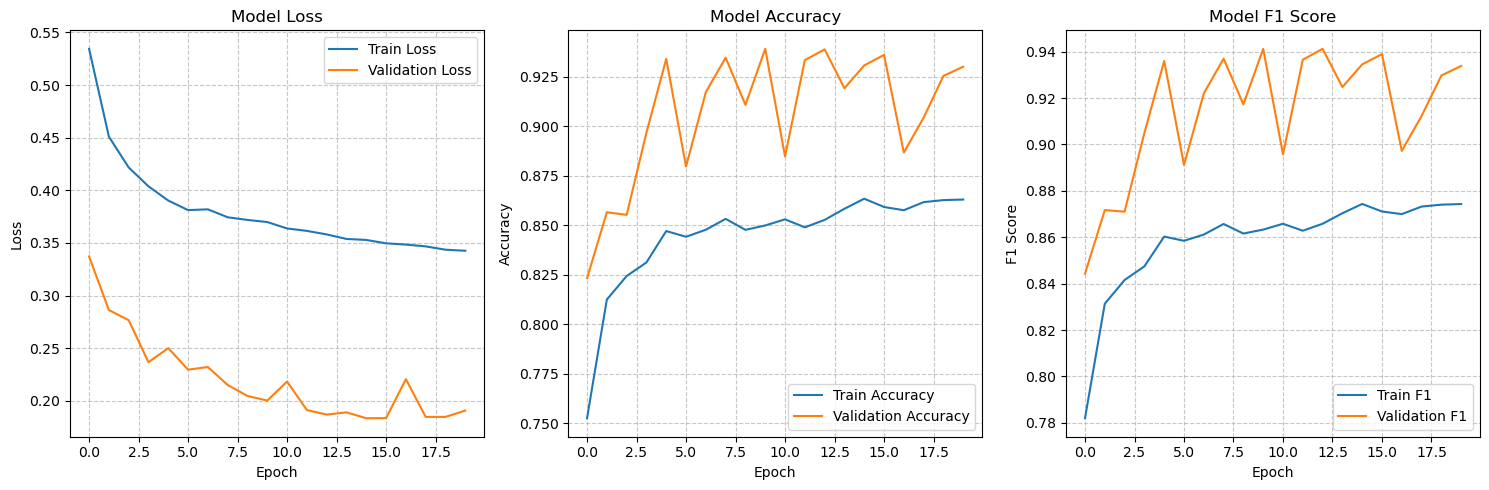


Evaluating model on test set:


Testing:   0%|          | 0/689 [00:00<?, ?it/s]

/gpfs/home/hz3106/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 0.9304
Precision: 0.9424 (Normal: 0.7090, Abnormal: 0.9839)
Recall: 0.9304 (Normal: 0.9140, Abnormal: 0.9333)
F1 Score: 0.9339 (Normal: 0.7985, Abnormal: 0.9579)

Confusion Matrix:
[[ 3040   286]
 [ 1248 17468]]


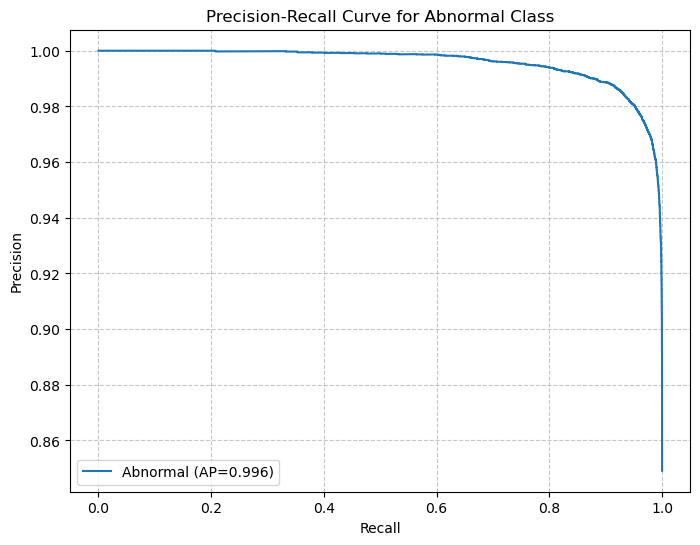

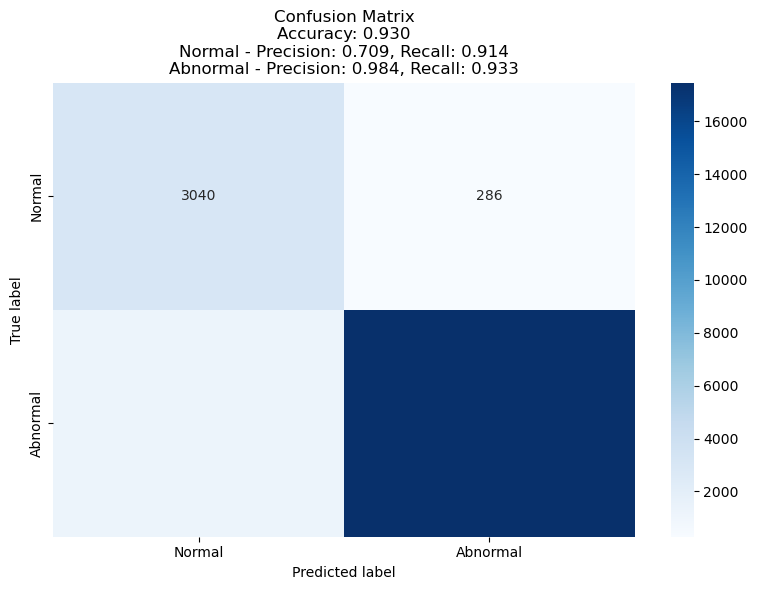

Model saved as models/weighted_gradual_fc_gastric_cnn_resnet.pth

Evaluating with different classification thresholds for abnormal class:

Threshold 0.3:
  Precision: 0.9529 (Normal: 0.8416, Abnormal: 0.9727)
  Recall: 0.9528 (Normal: 0.8467, Abnormal: 0.9717)
  F1 Score: 0.9529
  Confusion Matrix:
[[ 2816   510]
 [  530 18186]]

Threshold 0.4:
  Precision: 0.9481 (Normal: 0.7710, Abnormal: 0.9795)
  Recall: 0.9433 (Normal: 0.8879, Abnormal: 0.9531)
  F1 Score: 0.9449
  Confusion Matrix:
[[ 2953   373]
 [  877 17839]]

Threshold 0.5:
  Precision: 0.9424 (Normal: 0.7090, Abnormal: 0.9839)
  Recall: 0.9304 (Normal: 0.9140, Abnormal: 0.9333)
  F1 Score: 0.9339
  Confusion Matrix:
[[ 3040   286]
 [ 1248 17468]]

Threshold 0.6:
  Precision: 0.9365 (Normal: 0.6460, Abnormal: 0.9881)
  Recall: 0.9131 (Normal: 0.9384, Abnormal: 0.9086)
  F1 Score: 0.9193
  Confusion Matrix:
[[ 3121   205]
 [ 1710 17006]]

Threshold 0.7:
  Precision: 0.9264 (Normal: 0.5661, Abnormal: 0.9905)
  Recall: 0.8827 (N

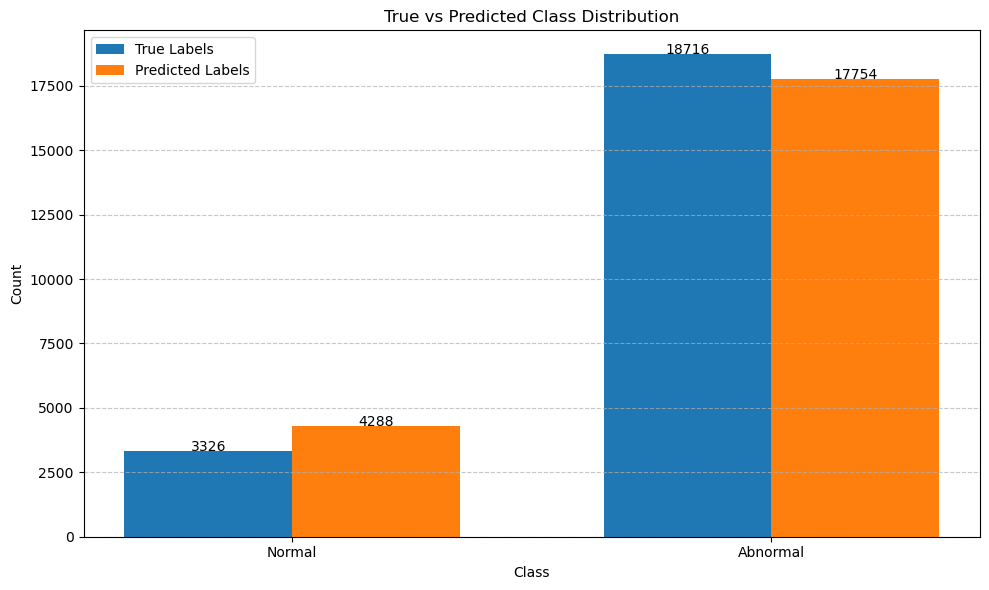

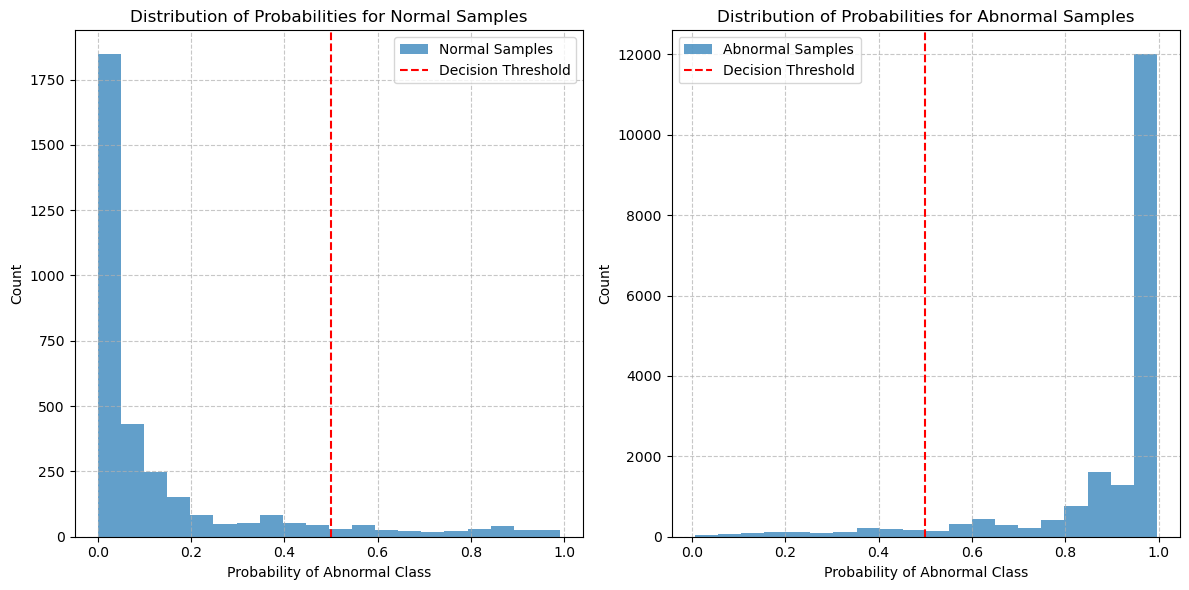


Probability Distribution Analysis:
Normal samples (true negative):
  - Average probability of being abnormal: 0.1333
  - Standard deviation: 0.2168
  - Correctly classified as normal: 91.40%

Abnormal samples (true positive):
  - Average probability of being abnormal: 0.8874
  - Standard deviation: 0.1884
  - Correctly classified as abnormal: 93.33%


{'normal_avg': 0.13333584,
 'normal_std': 0.21683405,
 'normal_below_threshold': 0.9140108238123873,
 'abnormal_avg': 0.88742244,
 'abnormal_std': 0.18842082,
 'abnormal_above_threshold': 0.9333190852746314}

In [3]:
model, history, metrics = run_weighted_gradual_fc_training(
    data_dir='/gpfs/scratch/hz3106/Gashisdb/Gashisdb_processed/120x120', 
    model_type='resnet',  # or 'custom'
    num_epochs=20
)

# Analyze results
analyze_class_distribution(metrics)
visualize_probabilities(metrics)